In [23]:
import os
import sys
import numpy as np
import tensorflow as tf
import input_data
import model_dropout as model
import time 
import matplotlib.pyplot as plt

In [24]:
# you need to change the directories to yours.
train_dir = '../PetImages/train_convert/'
test_dir = '../PetImages/test/'
train_logs_dir = '../logs/train/'
val_logs_dir = '../logs/val'

N_CLASSES = 2
IMG_W = 208     # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
RATIO = 0.2     # take 20% of dataset as validation data
BATCH_SIZE = 64
CAPACITY = 2000
MAX_STEP = 1000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001
models = {'drop_out':{}}

In [25]:
tf.reset_default_graph()

In [26]:
def training():
    
    train, train_label, val, val_label = input_data.get_files(train_dir, RATIO)
    train_batch, train_label_batch = input_data.get_batch(train,
                                                  train_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE,
                                                  CAPACITY)
    val_batch, val_label_batch = input_data.get_batch(val,
                                                  val_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE,
                                                  CAPACITY)
    
    #scale the float to -2.5 to 2.5
    train_batch = (1/(2*2.25)) * train_batch + 0.5

#     CNN卷积操作
    logits = model.inference(train_batch, BATCH_SIZE, N_CLASSES)
#    损失函数
    loss = model.losses(logits, train_label_batch)
#     梯度下降
    train_op = model.trainning(loss, learning_rate)
#     准确率
    acc = model.evaluation(logits, train_label_batch)

    
    x = tf.placeholder(tf.float32, shape=[BATCH_SIZE, IMG_W, IMG_H, 3])
    y_ = tf.placeholder(tf.int16, shape=[BATCH_SIZE])
    
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess= sess, coord=coord)
#         tensorboard查看
        summary_op = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(train_logs_dir, sess.graph)
        val_writer = tf.summary.FileWriter(val_logs_dir, sess.graph)

        steps_val = []
        accuracy_val = []
        loss_tr = []
        steps_tr = []
        accuracy_tr = []
        loss_val = []
        
        
        try:
            for step in np.arange(MAX_STEP):
                start = time.time()
                if coord.should_stop():
                        break
                tra_images,tra_labels = sess.run([train_batch, train_label_batch])
                _, tra_loss, tra_acc = sess.run([train_op, loss, acc],
                                                feed_dict={x:tra_images, y_:tra_labels})
                if step % 50 == 0:
                    print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))
                    summary_str = sess.run(summary_op)
                    steps_tr.append(step)
                    accuracy_tr.append(tra_acc)
                    loss_tr.append(tra_loss)
                    train_writer.add_summary(summary_str, step)

                if step % 50 == 0 or (step + 1) == MAX_STEP:
                    val_images, val_labels = sess.run([val_batch, val_label_batch])
                    val_loss, val_acc = sess.run([loss, acc],
                                                 feed_dict={x:val_images, y_:val_labels})
                    print('**  Step %d, val loss = %.2f, val accuracy = %.2f%%  **' %(step, val_loss, val_acc*100.0))
                    steps_val.append(step)
                    accuracy_val.append(val_acc)
                    loss_val.append(val_loss)
                    summary_str = sess.run(summary_op)
                    val_writer.add_summary(summary_str, step)

                if step % 2000 == 0 or (step + 1) == MAX_STEP:
                    checkpoint_path = os.path.join(train_logs_dir, 'model.ckpt')
                    saver.save(sess, checkpoint_path, global_step=step)
            time_used = time.time() - start
            models['drop_out'] = {'tr':{'steps_tr':steps_tr,'accuracy_tr':accuracy_tr,'tr_loss':loss_tr},
                                                  'val':{'steps_val':steps_val,'accuracy_val':accuracy_val,'val_loss':loss_val},
                                                  'times(s)':time_used}

        except tf.errors.OutOfRangeError:
            print('Done training -- epoch limit reached')
        finally:
            coord.request_stop()
        try:
            coord.join(threads)
        except:
            error_type, error_value, trace_back = sys.exc_info()
            print(error_value)


In [27]:
# 命令行输入: tensorboard  --logdir=/tmp/mnist 查看结果
# 浏览器输入:127.0.0.1:6006

In [29]:
# if __name__ == '__main__':
training()
# test_one_image()

There are 11309 cats
There are 11238 dogs


ValueError: Variable conv1/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/home/data/Desktop/ZhenchuanX/deep-60/day3_G/cats-dogs/refactor/model_dropout.py", line 19, in inference
    initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
  File "<ipython-input-26-0cd7f1a4416b>", line 21, in training
    logits = model.inference(train_batch, BATCH_SIZE, N_CLASSES)
  File "<ipython-input-28-a380071f81d7>", line 2, in <module>
    training()


In [30]:
models

{'drop_out': {'times(s)': 5.120329856872559,
  'tr': {'accuracy_tr': [0.64062,
    0.5625,
    0.45312,
    0.46875,
    0.64062,
    0.64062,
    0.57812,
    0.71875,
    0.60938,
    0.59375,
    0.64062,
    0.67188,
    0.53125,
    0.79688,
    0.53125,
    0.75,
    0.67188,
    0.5625,
    0.78125,
    0.60938],
   'steps_tr': [0,
    50,
    100,
    150,
    200,
    250,
    300,
    350,
    400,
    450,
    500,
    550,
    600,
    650,
    700,
    750,
    800,
    850,
    900,
    950],
   'tr_loss': [0.69232434,
    0.69114053,
    0.69497329,
    0.69317508,
    0.68915278,
    0.68722475,
    0.67633253,
    0.65313506,
    0.65644336,
    0.66997224,
    0.63180089,
    0.65035546,
    0.67255366,
    0.56119782,
    0.67560267,
    0.59766078,
    0.60440087,
    0.66215169,
    0.53772414,
    0.64003158]},
  'val': {'accuracy_val': [0.5,
    0.64062,
    0.48438,
    0.60938,
    0.57812,
    0.59375,
    0.5625,
    0.5,
    0.5625,
    0.57812,
    0.54688,

dropout used: 5.120329856872559s


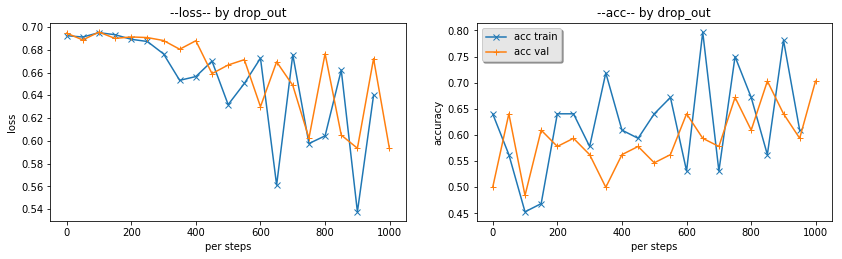

In [31]:
# 绘制loss的曲线
plt.figure(figsize=(14,8))
print('dropout used: '+ str(models['drop_out']['times(s)']) + 's')
plt.subplot(221)
plt.plot(models['drop_out']['tr']['steps_tr'],models['drop_out']['tr']['tr_loss'],"x-",label='train')
plt.plot(models['drop_out']['val']['steps_val'],models['drop_out']['val']['val_loss'],"+-",label='val')
plt.ylabel('loss')
plt.xlabel('per steps')
plt.title('--loss-- by drop_out')
legend = plt.legend(loc='best',shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

plt.subplot(222)
plt.plot(models['drop_out']['tr']['steps_tr'],models['drop_out']['tr']['accuracy_tr'],"x-",label='acc train')
plt.plot(models['drop_out']['val']['steps_val'],models['drop_out']['val']['accuracy_val'],"+-",label='acc val')
plt.ylabel('accuracy')
plt.xlabel('per steps')
plt.title('--acc-- by drop_out')


legend = plt.legend(loc='best',shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()